
# Loading Data

In [ ]:
pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.9 MB/s eta 0:00:00


In [1]:
import numpy as np
import h5py

In [ ]:
M_star = f['Subhalo/SubhaloMassType'][:,4]*1e10
pos  = f['Subhalo/SubhaloPos'][:]/1e3
vel = f['Subhalo/SubhaloVel'][:]
met = f['Subhalo/SubhaloStarMetallicity'][:]

In [2]:
def load_and_filter_data(file, mass_threshold=2e8):
    with h5py.File(file, 'r') as f:
        positions = f['Subhalo/SubhaloPos'][:]/1e3  # Convert to Mpc/h
        vel = f['Subhalo/SubhaloVel'][:]
        metallicities = f['Subhalo/SubhaloStarMetallicity'][:]
        masses = f['Subhalo/SubhaloMassType'][:,4]*1e10  # Stellar mass
        omega_m = f['Header'].attrs['Omega0']

    # Filter galaxies based on the stellar mass threshold
    mask = masses > mass_threshold
    positions = positions[mask]
    vel = vel[mask]
    metallicities = metallicities[mask]
    masses = masses[mask]

    return positions, vel, metallicities, masses, omega_m

In [3]:
def apply_periodic_boundary_conditions(positions, box_size):
    # Wrap positions to the box size
    positions = positions % box_size
    return positions

In [4]:
def minimum_image_distance(pos1, pos2, box_size):
    # Calculate the minimum image distance between two points
    delta = np.abs(pos1 - pos2)
    delta = np.where(delta > 0.5 * box_size, box_size - delta, delta)
    return np.sqrt((delta ** 2).sum(axis=-1))

In [5]:
from scipy.spatial import KDTree

def distance(point1, point2):
    return np.linalg.norm(point1 - point2)

def create_edges_knn(points, k=6):
    edges = []
    edge_value = []

    # Create a KDTree for efficient nearest neighbor search
    point_tree = KDTree(points)

    for i in range(len(points)):
        # Query the k nearest neighbors for each point
        _, neighbors = point_tree.query(points[i], k=k+1)

        for j in neighbors[1:]:  # Skip the first neighbor because it's the point itself
            # Add an edge between the point and its neighbor
            edges.append([i, j])

            # Compute the distance between the points as the edge value
            edge_value.append(distance(points[i], points[j]))

    return [edges, edge_value]

In [6]:
from tqdm import tqdm
def min_distance(positions, box_size = 25):
    min_distance = np.inf
    max_distance = 0

    # Iterate over all pairs of galaxies
    for i in range(len(positions)):
        for j in range(i + 1, len(positions)):
            dist = minimum_image_distance(positions[i], positions[j], box_size)
            if dist < min_distance:
                min_distance = dist
            if dist > max_distance:
                max_distance = dist

    # Print the results
    print(f"Minimum distance: {min_distance} Mpc/h")
    print(f"Maximum distance: {max_distance} Mpc/h")

In [7]:
def minimum_image_distance_vectorized(positions, box_size = 25):
    num_galaxies = positions.shape[0]

    # Compute pairwise differences in each dimension
    diff = positions[:, np.newaxis, :] - positions[np.newaxis, :, :]

    # Apply periodic boundary conditions
    diff = np.abs(diff)
    diff = np.where(diff > 0.5 * box_size, box_size - diff, diff)

    # Compute the Euclidean distance
    dist = np.sqrt(np.sum(diff ** 2, axis=-1))

    return dist

In [8]:
from tqdm import tqdm
from scipy.spatial import cKDTree
def create_edges_knn_pbc(points, box_size = 25, k=6):
    tree = KDTree(points, boxsize=box_size)

    edges = []
    edge_values = []
    '''
    distances = minimum_image_distance_vectorized(points, box_size)
    # Mask the diagonal (self-distances which are zero)
    np.fill_diagonal(distances, np.inf)
    # Get the minimum and maximum distances
    min_distance = np.min(distances)
    max_distance = np.max(np.triu(distances, k=1))
    print(min_distance, max_distance)
    '''

    min_distance = np.inf
    max_distance = 0
    large_distance_count = 0

    for i in range(len(points)):
        distances, neighbors = tree.query(points[i], k=k+1)
        for j, tree_dist in zip(neighbors[1:], distances[1:]):
            if j != i and j < len(points):
                actual_distance = minimum_image_distance(points[i], points[j], box_size)
                edges.append([i, j])
                edge_values.append(actual_distance)
                min_distance = min(min_distance, actual_distance)
                max_distance = max(max_distance, actual_distance)
    return np.array(edges), np.array(edge_values)


In [9]:
def create_points(positions, masses, vel, met):
    point_features = []
    for i, pos in enumerate(positions):
        #point_features.append(list(pos) + list(vel[i]) + [masses[i]] + [met[i]])
        point_features.append(list(pos) + [masses[i]] + [met[i]])
    return point_features

In [10]:
from torch_geometric.data import Data
import torch
def create_graph(file_path, k_val=6):
    positions, velocity, metallicities, masses, omega_m = load_and_filter_data(file_path)
    edges, edge_values = create_edges_knn_pbc(positions, 25, k_val)
    point_values = create_points(positions, masses, velocity, metallicities)

    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    point_values = torch.tensor(point_values, dtype=torch.float)
    edge_value = torch.tensor(edge_values, dtype=torch.float)

    return [point_values, edge_index, edge_value, omega_m]

In [11]:
def turn_data(graph):
    graph_data = Data(x=graph[0], edge_index=graph[1], edge_attr=graph[2], y = graph[3])
    return graph_data

In [12]:
import torch
torch.cuda.is_available()

True

In [13]:
import torch_geometric.transforms as T
def create_data(file_path, k_val=6):
    graph = create_graph(file_path, k_val)
    data = turn_data(graph)
    data = T.ToUndirected()(data)
    #data = T.NormalizeFeatures()(data)
    return data

In [14]:
def calculate_normalization_params(data_list):
    # Concatenate all node features and edge attributes
    all_x = torch.cat([data.x for data in data_list], dim=0)
    all_edge_attr = torch.cat([data.edge_attr for data in data_list], dim=0)

    # Calculate mean and std for node features and edge attributes
    x_mean, x_std = all_x.mean(dim=0), all_x.std(dim=0)
    edge_attr_mean, edge_attr_std = all_edge_attr.mean(dim=0), all_edge_attr.std(dim=0)

    return (x_mean, x_std), (edge_attr_mean, edge_attr_std)

def normalize_dataset(data_list, x_params, edge_attr_params):
    x_mean, x_std = x_params
    edge_attr_mean, edge_attr_std = edge_attr_params

    normalized_data_list = []
    for data in data_list:
        normalized_x = (data.x - x_mean) / (x_std + 1e-8)
        normalized_edge_attr = (data.edge_attr - edge_attr_mean) / (edge_attr_std + 1e-8)

        # Create a new Data object with normalized features and original y value
        normalized_data = Data(x=normalized_x,
                               edge_index=data.edge_index,
                               edge_attr=normalized_edge_attr,
                               y=data.y)  # Preserve the original y value

        normalized_data_list.append(normalized_data)

    return normalized_data_list

In [ ]:
import torch
import os
from torch.utils.data import random_split
from torch_geometric.data import DataLoader
import h5py
directory = '/scratch/gpfs/hk4638/FinalData/NewData'
def load_all_graphs(directory, k_val=10, box_size=25):
    file_list = os.listdir(directory)
    data_list = []
    for file_name in tqdm(file_list):
        file_path = os.path.join(directory, file_name)
        graph_data = create_data(file_path, k_val)
        data_list.append(graph_data)
    return data_list

# Load all graphs
data_list = load_all_graphs(directory)

# Calculate normalization parameters based on all graphs
x_params, edge_attr_params = calculate_normalization_params(data_list)

# Normalize the dataset using the calculated parameters
normalized_data_list = normalize_dataset(data_list, x_params, edge_attr_params)

import torch
import numpy as np

def numpy_to_torch_float(data):
    if isinstance(data, np.ndarray):
        return torch.from_numpy(data).float()
    elif isinstance(data, (np.float64, np.float32)):
        return torch.tensor(data, dtype=torch.float32)
    elif isinstance(data, torch.Tensor):
        return data.float()
    else:
        return data
        
def ensure_torch_float32(data):
    data.x = numpy_to_torch_float(data.x)
    data.edge_attr = numpy_to_torch_float(data.edge_attr)
    if hasattr(data, 'y'):
        data.y = numpy_to_torch_float(data.y)
    return data
    
normalized_data_list = [ensure_torch_float32(data) for data in normalized_data_list]

# Calculate the lengths for the 70-15-15 split
total_len = len(normalized_data_list)
train_len = int(0.7 * total_len)
val_len = int(0.15 * total_len)
test_len = total_len - train_len - val_len  # Ensures all data is used

# Perform the split
train_data, val_data, test_data = random_split(normalized_data_list, [train_len, val_len, test_len])

# Create DataLoaders for each split
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

 90%|█████████ | 903/1000 [03:03<00:20,  4.62it/s]

# Heterogenous 

In [21]:
import numpy as np
import h5py
import torch
from torch_geometric.data import HeteroData
from scipy.spatial import cKDTree
from tqdm import tqdm

def load_and_filter_data(file, mass_threshold=2e8):
    with h5py.File(file, 'r') as f:
        positions = f['Subhalo/SubhaloPos'][:]/1e3  # Convert to Mpc/h
        metallicities = f['Subhalo/SubhaloStarMetallicity'][:]
        masses = f['Subhalo/SubhaloMassType'][:,4]*1e10  # Stellar mass
        omega_m = f['Header'].attrs['Omega0']
    # Filter galaxies based on the stellar mass threshold
    mask = masses > mass_threshold
    return positions[mask], metallicities[mask], masses[mask], omega_m

def split_galaxies(positions, masses, metallicities, split_ratios):
    total_galaxies = len(positions)
    indices = np.random.permutation(total_galaxies)
    split_points = [int(ratio * total_galaxies) for ratio in np.cumsum(split_ratios)]
    
    a_indices = indices[:split_points[0]]
    b_indices = indices[split_points[0]:split_points[1]]
    c_indices = indices[split_points[1]:]
    
    return {
        'A': (positions[a_indices], masses[a_indices], metallicities[a_indices]),
        'B': (positions[b_indices], masses[b_indices], metallicities[b_indices]),
        'C': (positions[c_indices], masses[c_indices], metallicities[c_indices])
    }

def minimum_image_distance(pos1, pos2, box_size):
    delta = np.abs(pos1 - pos2)
    delta = np.where(delta > 0.5 * box_size, box_size - delta, delta)
    return np.sqrt((delta ** 2).sum(axis=-1))

def create_edges_hetero(node_data, box_size=25, k=6):
    all_positions = np.concatenate([node_data[t][0] for t in ['A', 'B', 'C']])
    tree = cKDTree(all_positions, boxsize=box_size)
    
    edge_dict = {}
    node_types = ['A', 'B', 'C']
    start_idx = {'A': 0, 'B': len(node_data['A'][0]), 'C': len(node_data['A'][0]) + len(node_data['B'][0])}
    
    for src_type in node_types:
        src_positions = node_data[src_type][0]
        for dst_type in node_types:
            dst_positions = node_data[dst_type][0]
            edges = []
            edge_attrs = []
            
            for i, pos in enumerate(src_positions):
                distances, neighbors = tree.query(pos, k=k+1)
                for j, dist in zip(neighbors[1:], distances[1:]):
                    if start_idx[dst_type] <= j < start_idx[dst_type] + len(dst_positions):
                        edges.append([i, j - start_idx[dst_type]])
                        if src_type != 'B' and dst_type != 'B':
                            actual_distance = minimum_image_distance(pos, all_positions[j], box_size)
                            edge_attrs.append([actual_distance])
                        else:
                            edge_attrs.append([0.0])  # Placeholder for B connections
            
            if edges:
                edge_dict[(src_type, 'to', dst_type)] = (np.array(edges).T, np.array(edge_attrs))
    
    return edge_dict

def create_heterogeneous_graph(file_path, split_ratios, k_val=6):
    positions, metallicities, masses, omega_m = load_and_filter_data(file_path)
    node_data = split_galaxies(positions, masses, metallicities, split_ratios)
    edge_dict = create_edges_hetero(node_data, k=k_val)
    
    data = HeteroData()
    
    # Add node features
    data['A'].x = torch.tensor(np.column_stack(node_data['A'][0:1]), dtype=torch.float) # only position for A
    data['B'].x = torch.tensor(np.column_stack(node_data['B'][1:]), dtype=torch.float)  # Exclude positions for B
    data['C'].x = torch.tensor(np.column_stack(node_data['C']), dtype=torch.float)
    
    # Add edges
    for edge_type, (edge_index, edge_attr) in edge_dict.items():
        data[edge_type].edge_index = torch.tensor(edge_index, dtype=torch.long)
        if edge_type[0] != 'B' and edge_type[2] != 'B':
            data[edge_type].edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    
    # Add global target
    data.y = torch.tensor([omega_m], dtype=torch.float)
    
    return data

def create_dataset(file_paths, split_ratios, k_val=6):
    dataset = []
    for file_path in tqdm(file_paths, desc="Creating dataset"):
        graph = create_heterogeneous_graph(file_path, split_ratios, k_val)
        graph = T.ToUndirected()(graph)
        dataset.append(graph)
    return dataset

def calculate_normalization_params(dataset):
    node_features = {node_type: [] for node_type in ['A', 'B', 'C']}
    edge_features = {edge_type: [] for edge_type in [('A', 'to', 'A'), ('A', 'to', 'C'), ('C', 'to', 'C')]}
    
    for data in dataset:
        for node_type in ['A', 'B', 'C']:
            node_features[node_type].append(data[node_type].x)
        
        for edge_type in [('A', 'to', 'A'), ('A', 'to', 'C'), ('C', 'to', 'C')]:
            if edge_type in data.edge_types and hasattr(data[edge_type], 'edge_attr'):
                edge_features[edge_type].append(data[edge_type].edge_attr)
    
    norm_params = {}
    for node_type, features in node_features.items():
        if features:
            features = torch.cat(features, dim=0)
            norm_params[f'{node_type}_mean'] = features.mean(dim=0)
            norm_params[f'{node_type}_std'] = features.std(dim=0)
    
    for edge_type, features in edge_features.items():
        if features:
            features = torch.cat(features, dim=0)
            norm_params[f'{edge_type}_mean'] = features.mean(dim=0)
            norm_params[f'{edge_type}_std'] = features.std(dim=0)
    
    return norm_params

def normalize_graph(graph, norm_params):
    for node_type in ['A', 'B', 'C']:
        mean = norm_params[f'{node_type}_mean']
        std = norm_params[f'{node_type}_std']
        graph[node_type].x = (graph[node_type].x - mean) / (std + 1e-8)
    
    for edge_type in [('A', 'to', 'A'), ('A', 'to', 'C'), ('C', 'to', 'C')]:
        if edge_type in graph.edge_types and hasattr(graph[edge_type], 'edge_attr'):
            mean = norm_params[f'{edge_type}_mean']
            std = norm_params[f'{edge_type}_std']
            graph[edge_type].edge_attr = (graph[edge_type].edge_attr - mean) / (std + 1e-8)
    
    return graph

def normalize_dataset(dataset):
    norm_params = calculate_normalization_params(dataset)
    normalized_dataset = [normalize_graph(graph, norm_params) for graph in dataset]
    return normalized_dataset, norm_params

In [22]:
import torch
import os
from torch.utils.data import random_split
from torch_geometric.loader import DataLoader
import h5py
from tqdm import tqdm

# Assuming the previously defined functions are available:
# create_heterogeneous_graph, calculate_normalization_params, normalize_graph

directory = '/scratch/gpfs/hk4638/FinalData/NewData'

def load_all_heterogeneous_graphs(directory, split_ratios, k_val=10, box_size=25):
    file_list = os.listdir(directory)
    data_list = []
    for file_name in tqdm(file_list, desc="Loading graphs"):
        file_path = os.path.join(directory, file_name)
        graph_data = create_heterogeneous_graph(file_path, split_ratios, k_val)
        data_list.append(graph_data)
    return data_list

# Load all heterogeneous graphs
split_ratios = [0.3, 0.3, 0.4]  # 30% A, 30% B, 40% C
data_list = load_all_heterogeneous_graphs(directory, split_ratios)

# Calculate normalization parameters based on all graphs
norm_params = calculate_normalization_params(data_list)

# Normalize the dataset using the calculated parameters
normalized_data_list = [normalize_graph(graph, norm_params) for graph in data_list]

def ensure_torch_float32(data):
    for node_type in data.node_types:
        data[node_type].x = torch.tensor(data[node_type].x, dtype=torch.float32)
    for edge_type in data.edge_types:
        if hasattr(data[edge_type], 'edge_attr'):
            data[edge_type].edge_attr = torch.tensor(data[edge_type].edge_attr, dtype=torch.float32)
    data.y = torch.tensor(data.y, dtype=torch.float32)
    return data

normalized_data_list = [ensure_torch_float32(data) for data in normalized_data_list]

# Calculate the lengths for the 70-15-15 split
total_len = len(normalized_data_list)
train_len = int(0.7 * total_len)
val_len = int(0.15 * total_len)
test_len = total_len - train_len - val_len  # Ensures all data is used

# Perform the split
train_data, val_data, test_data = random_split(normalized_data_list, [train_len, val_len, test_len])

# Create DataLoaders for each split
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Print some information about the dataset
print(f"Total number of graphs: {total_len}")
print(f"Number of training graphs: {train_len}")
print(f"Number of validation graphs: {val_len}")
print(f"Number of test graphs: {test_len}")

Loading graphs: 100%|██████████| 1000/1000 [02:11<00:00,  7.58it/s]
/tmp/ipykernel_2029888/3858287339.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data[node_type].x = torch.tensor(data[node_type].x, dtype=torch.float32)
/tmp/ipykernel_2029888/3858287339.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data[edge_type].edge_attr = torch.tensor(data[edge_type].edge_attr, dtype=torch.float32)
/tmp/ipykernel_2029888/3858287339.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data.y = torch.tensor(data.y, dtype=torch.float32)


Total number of graphs: 1000
Number of training graphs: 700
Number of validation graphs: 150
Number of test graphs: 150


# Training Model

## Models

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, GATv2Conv, global_mean_pool

class ComplexGAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_layers=4, heads=4, dropout_rate=0.1):
        super(ComplexGAT, self).__init__()
        self.dropout_rate = dropout_rate

        self.conv1 = GATv2Conv(in_channels, hidden_channels, heads=heads, concat=True, edge_dim=1)
        #self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, concat=True, edge_dim=1)

        self.convs = nn.ModuleList([
            GATv2Conv(hidden_channels * heads, hidden_channels, heads=heads, concat=True, edge_dim=1)
            #GATConv(hidden_channels * heads, hidden_channels, heads=heads, concat=True, edge_dim=1)
            for _ in range(num_layers - 2)
        ])

        self.conv_last = GATv2Conv(hidden_channels * heads, hidden_channels, heads=1, concat=False, edge_dim=1)
        #self.conv_last = GATConv(hidden_channels * heads, hidden_channels, heads=1, concat=False, edge_dim=1)

        self.fc1 = nn.Linear(hidden_channels, hidden_channels)
        self.fc2 = nn.Linear(hidden_channels, 1)  # Output a single value for omega_m

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch

        x = F.relu(self.conv1(x, edge_index, edge_attr=edge_attr))
        x = F.dropout(x, p=self.dropout_rate, training=self.training)

        for conv in self.convs:
            x = F.relu(conv(x, edge_index, edge_attr=edge_attr))
            x = F.dropout(x, p=self.dropout_rate, training=self.training)

        x = self.conv_last(x, edge_index, edge_attr=edge_attr)

        x = global_mean_pool(x, batch)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x.squeeze()

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, GATv2Conv, global_mean_pool

class ComplexGAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_layers=4, heads=4, dropout_rate=0.1):
        super(ComplexGAT, self).__init__()
        self.dropout_rate = dropout_rate

        # First GAT layer
        self.conv1 = GATv2Conv(in_channels, hidden_channels, heads=heads, concat=True, edge_dim=1)
        self.ln1 = nn.LayerNorm(hidden_channels * heads)  # LayerNorm after first layer

        # Intermediate GAT layers
        self.convs = nn.ModuleList([
            GATv2Conv(hidden_channels * heads, hidden_channels, heads=heads, concat=True, edge_dim=1)
            for _ in range(num_layers - 2)
        ])
        self.lns = nn.ModuleList([nn.LayerNorm(hidden_channels * heads) for _ in range(num_layers - 2)])

        # Final GAT layer
        self.conv_last = GATv2Conv(hidden_channels * heads, hidden_channels, heads=1, concat=False, edge_dim=1)
        self.ln_last = nn.LayerNorm(hidden_channels)  # LayerNorm after last layer

        # Fully connected layers
        self.fc1 = nn.Linear(hidden_channels, hidden_channels)
        self.fc2 = nn.Linear(hidden_channels, 1)  # Output a single value for omega_m

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch

        # First GAT layer with LayerNorm
        x = self.conv1(x, edge_index, edge_attr=edge_attr)
        x = self.ln1(x)  # Apply LayerNorm
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout_rate, training=self.training)

        # Intermediate GAT layers with LayerNorm
        for conv, ln in zip(self.convs, self.lns):
            x = conv(x, edge_index, edge_attr=edge_attr)
            x = ln(x)  # Apply LayerNorm
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout_rate, training=self.training)

        # Final GAT layer with LayerNorm
        x = self.conv_last(x, edge_index, edge_attr=edge_attr)
        x = self.ln_last(x)  # Apply LayerNorm
        x = F.relu(x)

        # Global mean pooling
        x = global_mean_pool(x, batch)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x.squeeze()

In [34]:
import torch_scatter

ModuleNotFoundError: No module named 'torch_scatter'

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MetaLayer, global_add_pool, global_mean_pool, global_max_pool
from torch.utils.checkpoint import checkpoint

class EdgeModel(nn.Module):
    def __init__(self, node_in, edge_in, hidden_channels, edge_out):
        super().__init__()
        self.edge_mlp = nn.Sequential(
            nn.Linear(node_in*2 + edge_in, hidden_channels),
            nn.LayerNorm(hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, hidden_channels),
            nn.LayerNorm(hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, edge_out),
            nn.LayerNorm(edge_out)
        )
        self.residual_proj = nn.Linear(edge_in, edge_out) if edge_in != edge_out else nn.Identity()

    def forward(self, src, dest, edge_attr, u, batch):
        out = torch.cat([src, dest, edge_attr], dim=1)
        out = self.edge_mlp(out)
        out = out + self.residual_proj(edge_attr)
        return out

class NodeModel(nn.Module):
    def __init__(self, node_in, edge_in, hidden_channels, node_out):
        super().__init__()
        self.node_mlp = nn.Sequential(
            nn.Linear(node_in + edge_in*3, hidden_channels),
            nn.LayerNorm(hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, hidden_channels),
            nn.LayerNorm(hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, node_out),
            nn.LayerNorm(node_out)
        )
        self.residual_proj = nn.Linear(node_in, node_out) if node_in != node_out else nn.Identity()

    def forward(self, x, edge_index, edge_attr, u, batch):
        row, col = edge_index
        
        out1 = torch.zeros(x.size(0), edge_attr.size(1), device=x.device).index_add_(0, col, edge_attr)
        out2 = torch.zeros(x.size(0), edge_attr.size(1), device=x.device).index_add_(0, col, edge_attr)
        out2 = torch.max(out2, out1)
        out3 = out1 / (torch.zeros(x.size(0), 1, device=x.device).index_add_(0, col, torch.ones_like(edge_attr[:, :1])) + 1e-8)
        
        out = torch.cat([x, out1, out2, out3], dim=1)
        out = self.node_mlp(out)
        out = out + self.residual_proj(x)
        return out

class GlobalModel(nn.Module):
    def __init__(self, node_in, edge_in, hidden_channels, global_out):
        super().__init__()
        self.global_mlp = nn.Sequential(
            nn.Linear(node_in + edge_in + 1, hidden_channels),
            nn.LayerNorm(hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, hidden_channels),
            nn.LayerNorm(hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, global_out),
            nn.LayerNorm(global_out)
        )

    def forward(self, x, edge_index, edge_attr, u, batch):
        row, col = edge_index
        out = torch.cat([
            global_mean_pool(x, batch),
            global_mean_pool(edge_attr, batch[row]),
            u
        ], dim=1)
        return self.global_mlp(out)

class MetaLayerGNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels=1, num_layers=4, dropout_rate=0.1):
        super(MetaLayerGNN, self).__init__()
        
        self.node_encoder = nn.Sequential(
            nn.Linear(in_channels, hidden_channels),
            nn.LayerNorm(hidden_channels)
        )
        self.edge_encoder = nn.Sequential(
            nn.Linear(1, hidden_channels),
            nn.LayerNorm(hidden_channels)
        )

        self.layers = nn.ModuleList()
        for _ in range(num_layers):
            edge_model = EdgeModel(hidden_channels, hidden_channels, hidden_channels, hidden_channels)
            node_model = NodeModel(hidden_channels, hidden_channels, hidden_channels, hidden_channels)
            global_model = GlobalModel(hidden_channels, hidden_channels, hidden_channels, 1)
            self.layers.append(MetaLayer(edge_model, node_model, global_model))

        self.output_layer = nn.Sequential(
            nn.Linear(hidden_channels * 3 + 1, hidden_channels),
            nn.LayerNorm(hidden_channels),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_channels, hidden_channels),
            nn.LayerNorm(hidden_channels),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_channels, out_channels)
        )

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        u = torch.zeros(batch.max().item() + 1, 1, device=x.device)

        x = self.node_encoder(x)
        edge_attr = self.edge_encoder(edge_attr.unsqueeze(1))

        for layer in self.layers:
            x, edge_attr, u = checkpoint(layer, x, edge_index, edge_attr, u, batch)
            x = F.relu(x)
            edge_attr = F.relu(edge_attr)

        add_pool = global_add_pool(x, batch)
        mean_pool = global_mean_pool(x, batch)
        max_pool = global_max_pool(x, batch)

        out = torch.cat([add_pool, mean_pool, max_pool, u], dim=1)
        out = self.output_layer(out)

        return out.squeeze()

In [33]:
import torch
import torch.nn as nn
from torch_geometric.nn import HeteroConv, GATConv, SAGEConv, global_mean_pool

class HeteroComplexGAT(torch.nn.Module):
    def __init__(self, in_channels_dict, hidden_channels, num_layers=4, heads=4, dropout_rate=0.1):
        super(HeteroComplexGAT, self).__init__()
        self.dropout_rate = dropout_rate

        # Input to same dimentions
        self.lin_dict = nn.ModuleDict({
            node_type: nn.Linear(in_channels_dict[node_type], hidden_channels * heads)
            for node_type in in_channels_dict
        })

        
        edge_types = [
            ('A', 'to', 'A'), ('A', 'to', 'C'), ('C', 'to', 'A'), ('B', 'to', 'B'), ('B', 'to', 'C'), ('C', 'to', 'B'), ('C', 'to', 'C')
        ]

        # Initialize the first layer using HeteroConv with GATConv or SAGEConv depending on edge types
        self.conv1 = HeteroConv({
            edge_type: (GATConv(hidden_channels * heads, hidden_channels, heads=heads, concat=True, add_self_loops=False, edge_dim=1) 
                        if edge_type[0] != 'B' and edge_type[2] != 'B' 
                        else SAGEConv(hidden_channels * heads, hidden_channels * heads))
            for edge_type in edge_types
        })

        self.convs = nn.ModuleList()
        for _ in range(num_layers - 2):
            conv = HeteroConv({
                edge_type: (GATConv(hidden_channels * heads, hidden_channels, heads=heads, concat=True, add_self_loops=False, edge_dim=1)
                            if edge_type[0] != 'B' and edge_type[2] != 'B'
                            else SAGEConv(hidden_channels * heads, hidden_channels * heads))
                for edge_type in edge_types
            })
            self.convs.append(conv)

        self.conv_last = HeteroConv({
            edge_type: (GATConv(hidden_channels * heads, hidden_channels, heads=1, concat=False, add_self_loops=False, edge_dim=1)
                        if edge_type[0] != 'B' and edge_type[2] != 'B'
                        else SAGEConv(hidden_channels * heads, hidden_channels))
            for edge_type in edge_types
        })

        self.fc1 = nn.Linear(hidden_channels * len(in_channels_dict), hidden_channels)
        self.fc2 = nn.Linear(hidden_channels, 1)  # Output a single value for omega_m

    def forward(self, data):
        x_dict, edge_index_dict, edge_attr_dict = data.x_dict, data.edge_index_dict, data.edge_attr_dict

        # Apply initial linear transformation to standardize input dimensions
        x_dict = {key: self.lin_dict[key](x) for key, x in x_dict.items()}

        # Apply convolutional layers
        x_dict = self.conv1(x_dict, edge_index_dict, edge_attr_dict)
        x_dict = {key: nn.functional.relu(x) for key, x in x_dict.items()}
        x_dict = {key: nn.functional.dropout(x, p=self.dropout_rate, training=self.training) for key, x in x_dict.items()}

        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict, edge_attr_dict)
            x_dict = {key: nn.functional.relu(x) for key, x in x_dict.items()}
            x_dict = {key: nn.functional.dropout(x, p=self.dropout_rate, training=self.training) for key, x in x_dict.items()}

        x_dict = self.conv_last(x_dict, edge_index_dict, edge_attr_dict)

        # Global mean pooling
        x = torch.cat([global_mean_pool(x, data[node_type].batch) for node_type, x in x_dict.items()], dim=1)

        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x.squeeze()

In [55]:
def train_model(model, train_loader, val_loader, device, num_epochs=100, load_best_model=False):
    model = model.to(device)
    
    if load_best_model:
        try:
            model.load_state_dict(torch.load('/scratch/gpfs/hk4638/astrid_optimization/model_54.pth'))
            print("Loaded model from best_model.pth")
        except FileNotFoundError:
            print("best_model.pth not found. Starting with a new model.")
    lear_r = 0.01
    #lear_r = 0.0008
    #lear_r = 0.0008
    optimizer = optim.Adam(model.parameters(), lr=lear_r)  # Start with the highest learning rate
    criterion = nn.MSELoss()
    best_val_loss = float('inf')
    best_model = None
    
    # Define a learning rate scheduler that adjusts the learning rate based on epoch
    '''scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 
                                            0.01 if epoch < 75 else
                                            0.002 if epoch < 150 else
                                            0.0004 if epoch < 225 else
                                            0.00008)'''
    
    train_losses = []
    val_losses = []
    val_mses = []
    val_r2s = []
    
    try:
        for epoch in range(num_epochs):
            model.train()
            train_loss = 0
            epoch_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
            for data in epoch_pbar:
                data = data.to(device)
                optimizer.zero_grad()
                out = model(data)
                loss = criterion(out, data.y)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                epoch_pbar.set_postfix({'Train Loss': f'{loss.item():.4f}'})
            
            # Step the scheduler to potentially adjust the learning rate
            #scheduler.step()
            
            model.eval()
            val_loss = 0
            val_predictions = []
            val_true = []
            with torch.no_grad():
                for data in val_loader:
                    data = data.to(device)
                    out = model(data)
                    val_loss += criterion(out, data.y).item()
                    val_predictions.extend(out.cpu().numpy())
                    val_true.extend(data.y.cpu().numpy())
            
            train_loss /= len(train_loader)
            val_loss /= len(val_loader)
            val_mse = mean_squared_error(val_true, val_predictions)
            val_r2 = r2_score(val_true, val_predictions)
            
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            val_mses.append(val_mse)
            val_r2s.append(val_r2)
            
            print(f'Epoch {epoch+1}/{num_epochs}:')
            print(f'  Train Loss: {train_loss:.4f}')
            print(f'  Val Loss: {val_loss:.4f}')
            print(f'  Val MSE: {val_mse:.4f}')
            print(f'  Val R2: {val_r2:.4f}')
            
            # Save the model after each epoch
            torch.save(model.state_dict(), f'model_epoch_{epoch+1}.pth')
            print(f'  Model saved as model_epoch_{epoch+1}.pth')
            
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = model.state_dict()
                torch.save(best_model, 'best_model.pth')
                print('  New best model saved as best_model.pth!')
            
            print()  # Add an empty line for better readability between epochs
    
    except KeyboardInterrupt:
        print("\nTraining interrupted. Saving current model state...")
        torch.save(model.state_dict(), 'interrupted_model.pth')
        print("Model saved as interrupted_model.pth")
        if best_model is not None:
            model.load_state_dict(best_model)
        return model, train_losses, val_losses, val_mses, val_r2s
    
    # Load the best model if training completed without interruption
    if best_model is not None:
        model.load_state_dict(best_model)
    
    return model, train_losses, val_losses, val_mses, val_r2s


In [56]:
import torch
from torch_geometric.loader import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, r2_score

# Initialize model
in_channels = normalized_data_list[0].num_node_features
hidden_channels = 64
out_channels = 1  # Assuming you're predicting a single value
num_layers = 3
heads = 16
dropout_rate = 0.16841713216269857
residuals = True

model = MetaLayerGNN(
    in_channels=in_channels, 
    hidden_channels=hidden_channels, 
    out_channels=out_channels, 
    num_layers=num_layers, 
    dropout_rate=dropout_rate
)

# Train model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = train_model(model, train_loader, val_loader, device, num_epochs=1000, load_best_model=False)

Epoch 1/1000: 100%|██████████| 22/22 [00:03<00:00,  5.65it/s, Train Loss=0.0275]
/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Epoch 1/1000:
  Train Loss: 0.1666
  Val Loss: 0.0122
  Val MSE: 0.0124
  Val R2: -0.0820
  Model saved as model_epoch_1.pth
  New best model saved as best_model.pth!



Epoch 2/1000:   0%|          | 0/22 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
Epoch 2/1000: 100%|██████████| 22/22 [00:03<00:00,  5.77it/s, Train Loss=0.0124]
/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients w

Epoch 2/1000:
  Train Loss: 0.0198
  Val Loss: 0.0114
  Val MSE: 0.0114
  Val R2: 0.0001
  Model saved as model_epoch_2.pth
  New best model saved as best_model.pth!



Epoch 3/1000:   0%|          | 0/22 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
Epoch 3/1000: 100%|██████████| 22/22 [00:03<00:00,  5.77it/s, Train Loss=0.0217]
/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients w

Epoch 3/1000:
  Train Loss: 0.0172
  Val Loss: 0.0115
  Val MSE: 0.0115
  Val R2: -0.0049
  Model saved as model_epoch_3.pth



Epoch 4/1000:   0%|          | 0/22 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
Epoch 4/1000: 100%|██████████| 22/22 [00:03<00:00,  5.79it/s, Train Loss=0.0141]
/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients w

Epoch 4/1000:
  Train Loss: 0.0155
  Val Loss: 0.0115
  Val MSE: 0.0115
  Val R2: -0.0035
  Model saved as model_epoch_4.pth



Epoch 5/1000:   0%|          | 0/22 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
Epoch 5/1000: 100%|██████████| 22/22 [00:03<00:00,  5.82it/s, Train Loss=0.0135]
/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients w

Epoch 5/1000:
  Train Loss: 0.0152
  Val Loss: 0.0114
  Val MSE: 0.0114
  Val R2: -0.0007
  Model saved as model_epoch_5.pth



Epoch 6/1000:   0%|          | 0/22 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
Epoch 6/1000: 100%|██████████| 22/22 [00:03<00:00,  5.77it/s, Train Loss=0.0160]
/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients w

Epoch 6/1000:
  Train Loss: 0.0157
  Val Loss: 0.0119
  Val MSE: 0.0120
  Val R2: -0.0516
  Model saved as model_epoch_6.pth



Epoch 7/1000:   0%|          | 0/22 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
Epoch 7/1000: 100%|██████████| 22/22 [00:03<00:00,  5.83it/s, Train Loss=0.0138]
/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients w

Epoch 7/1000:
  Train Loss: 0.0158
  Val Loss: 0.0126
  Val MSE: 0.0125
  Val R2: -0.0946
  Model saved as model_epoch_7.pth



Epoch 8/1000:   0%|          | 0/22 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
Epoch 8/1000: 100%|██████████| 22/22 [00:03<00:00,  5.75it/s, Train Loss=0.0155]
/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients w

Epoch 8/1000:
  Train Loss: 0.0154
  Val Loss: 0.0118
  Val MSE: 0.0119
  Val R2: -0.0385
  Model saved as model_epoch_8.pth



Epoch 9/1000:   0%|          | 0/22 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
Epoch 9/1000: 100%|██████████| 22/22 [00:03<00:00,  5.69it/s, Train Loss=0.0122]
/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients w

Epoch 9/1000:
  Train Loss: 0.0155
  Val Loss: 0.0115
  Val MSE: 0.0116
  Val R2: -0.0128
  Model saved as model_epoch_9.pth



Epoch 10/1000:   0%|          | 0/22 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
Epoch 10/1000: 100%|██████████| 22/22 [00:03<00:00,  5.77it/s, Train Loss=0.0131]
/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients

Epoch 10/1000:
  Train Loss: 0.0152
  Val Loss: 0.0116
  Val MSE: 0.0116
  Val R2: -0.0186
  Model saved as model_epoch_10.pth



Epoch 11/1000:   0%|          | 0/22 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
Epoch 11/1000: 100%|██████████| 22/22 [00:03<00:00,  5.72it/s, Train Loss=0.0205]
/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients

Epoch 11/1000:
  Train Loss: 0.0151
  Val Loss: 0.0122
  Val MSE: 0.0122
  Val R2: -0.0647
  Model saved as model_epoch_11.pth



Epoch 12/1000:   0%|          | 0/22 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
Epoch 12/1000: 100%|██████████| 22/22 [00:03<00:00,  5.76it/s, Train Loss=0.0148]
/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients

Epoch 12/1000:
  Train Loss: 0.0151
  Val Loss: 0.0115
  Val MSE: 0.0115
  Val R2: -0.0034
  Model saved as model_epoch_12.pth



Epoch 13/1000:   0%|          | 0/22 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
Epoch 13/1000: 100%|██████████| 22/22 [00:03<00:00,  5.75it/s, Train Loss=0.0179]
/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients

Epoch 13/1000:
  Train Loss: 0.0151
  Val Loss: 0.0125
  Val MSE: 0.0125
  Val R2: -0.0900
  Model saved as model_epoch_13.pth



Epoch 14/1000:   0%|          | 0/22 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
Epoch 14/1000: 100%|██████████| 22/22 [00:03<00:00,  5.76it/s, Train Loss=0.0136]
/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients

Epoch 14/1000:
  Train Loss: 0.0158
  Val Loss: 0.0118
  Val MSE: 0.0118
  Val R2: -0.0341
  Model saved as model_epoch_14.pth



Epoch 15/1000:   0%|          | 0/22 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
Epoch 15/1000: 100%|██████████| 22/22 [00:03<00:00,  5.75it/s, Train Loss=0.0178]
/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients

Epoch 15/1000:
  Train Loss: 0.0151
  Val Loss: 0.0111
  Val MSE: 0.0112
  Val R2: 0.0235
  Model saved as model_epoch_15.pth
  New best model saved as best_model.pth!



Epoch 16/1000:   0%|          | 0/22 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
Epoch 16/1000: 100%|██████████| 22/22 [00:03<00:00,  5.77it/s, Train Loss=0.0179]
/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients

Epoch 16/1000:
  Train Loss: 0.0148
  Val Loss: 0.0124
  Val MSE: 0.0124
  Val R2: -0.0809
  Model saved as model_epoch_16.pth



Epoch 17/1000:   0%|          | 0/22 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
Epoch 17/1000: 100%|██████████| 22/22 [00:03<00:00,  5.74it/s, Train Loss=0.0119]
/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients

Epoch 17/1000:
  Train Loss: 0.0142
  Val Loss: 0.0108
  Val MSE: 0.0109
  Val R2: 0.0449
  Model saved as model_epoch_17.pth
  New best model saved as best_model.pth!



Epoch 18/1000:   0%|          | 0/22 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
Epoch 18/1000: 100%|██████████| 22/22 [00:03<00:00,  5.75it/s, Train Loss=0.0120]
/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients

Epoch 18/1000:
  Train Loss: 0.0138
  Val Loss: 0.0153
  Val MSE: 0.0156
  Val R2: -0.3608
  Model saved as model_epoch_18.pth



Epoch 19/1000:   0%|          | 0/22 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
Epoch 19/1000: 100%|██████████| 22/22 [00:03<00:00,  5.62it/s, Train Loss=0.0123]
/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients

Epoch 19/1000:
  Train Loss: 0.0163
  Val Loss: 0.0124
  Val MSE: 0.0123
  Val R2: -0.0772
  Model saved as model_epoch_19.pth



Epoch 20/1000:   0%|          | 0/22 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
Epoch 20/1000: 100%|██████████| 22/22 [00:03<00:00,  5.81it/s, Train Loss=0.0162]
/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients

Epoch 20/1000:
  Train Loss: 0.0142
  Val Loss: 0.0109
  Val MSE: 0.0110
  Val R2: 0.0389
  Model saved as model_epoch_20.pth



Epoch 21/1000:   0%|          | 0/22 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
Epoch 21/1000: 100%|██████████| 22/22 [00:03<00:00,  5.72it/s, Train Loss=0.0159]
/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients

Epoch 21/1000:
  Train Loss: 0.0145
  Val Loss: 0.0110
  Val MSE: 0.0110
  Val R2: 0.0369
  Model saved as model_epoch_21.pth



Epoch 22/1000:   0%|          | 0/22 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
Epoch 22/1000: 100%|██████████| 22/22 [00:03<00:00,  5.73it/s, Train Loss=0.0169]
/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients

Epoch 22/1000:
  Train Loss: 0.0147
  Val Loss: 0.0111
  Val MSE: 0.0111
  Val R2: 0.0318
  Model saved as model_epoch_22.pth



Epoch 23/1000:   0%|          | 0/22 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
Epoch 23/1000: 100%|██████████| 22/22 [00:03<00:00,  5.77it/s, Train Loss=0.0160]
/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients

Epoch 23/1000:
  Train Loss: 0.0137
  Val Loss: 0.0116
  Val MSE: 0.0116
  Val R2: -0.0163
  Model saved as model_epoch_23.pth



Epoch 24/1000:   0%|          | 0/22 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
Epoch 24/1000: 100%|██████████| 22/22 [00:03<00:00,  5.77it/s, Train Loss=0.0147]
/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients

Epoch 24/1000:
  Train Loss: 0.0147
  Val Loss: 0.0113
  Val MSE: 0.0113
  Val R2: 0.0083
  Model saved as model_epoch_24.pth



Epoch 25/1000:   0%|          | 0/22 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
Epoch 25/1000: 100%|██████████| 22/22 [00:03<00:00,  5.73it/s, Train Loss=0.0155]
/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients

Epoch 25/1000:
  Train Loss: 0.0136
  Val Loss: 0.0111
  Val MSE: 0.0112
  Val R2: 0.0217
  Model saved as model_epoch_25.pth



Epoch 26/1000:   0%|          | 0/22 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
Epoch 26/1000: 100%|██████████| 22/22 [00:03<00:00,  5.71it/s, Train Loss=0.0168]
/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients

Epoch 26/1000:
  Train Loss: 0.0136
  Val Loss: 0.0102
  Val MSE: 0.0103
  Val R2: 0.1017
  Model saved as model_epoch_26.pth
  New best model saved as best_model.pth!



Epoch 27/1000:   0%|          | 0/22 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
Epoch 27/1000: 100%|██████████| 22/22 [00:03<00:00,  5.73it/s, Train Loss=0.0110]
/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients

Epoch 27/1000:
  Train Loss: 0.0135
  Val Loss: 0.0114
  Val MSE: 0.0114
  Val R2: 0.0021
  Model saved as model_epoch_27.pth



Epoch 28/1000:   0%|          | 0/22 [00:00<?, ?it/s]/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/hk4638/.conda/envs/com/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
Epoch 28/1000:  91%|█████████ | 20/22 [00:03<00:00,  5.57it/s, Train Loss=0.0119]



Training interrupted. Saving current model state...
Model saved as interrupted_model.pth


In [ ]:
import torch
from torch_geometric.loader import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, r2_score

# Assuming normalized_data_list is a list of HeteroData objects
# Define input channels for each node type (example: {'A': 16, 'B': 32, 'C': 64})
# You'll need to replace these values with the actual number of features for each node type
in_channels_dict = {
    'A': normalized_data_list[0]['A'].num_node_features,
    'B': normalized_data_list[0]['B'].num_node_features,
    'C': normalized_data_list[0]['C'].num_node_features
}

# Initialize model with heterogeneous data
hidden_channels = 64
num_layers = 2
heads = 16
dropout_rate = 0.16841713216269857

# Use the HeteroComplexGAT model instead of ComplexGAT
model = HeteroComplexGAT(in_channels_dict, hidden_channels, num_layers, heads, dropout_rate)

# Train model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Assuming train_loader and val_loader are DataLoader objects for HeteroData
trained_model = train_model(model, train_loader, val_loader, device, num_epochs=1000, load_best_model=False)

# Optionally, plot the loss curve or evaluate the model further here

Epoch 1/1000: 100%|██████████| 22/22 [02:42<00:00,  7.38s/it, Train Loss=0.2628]   


Epoch 1/1000:
  Train Loss: 3236.5800
  Val Loss: 0.4463
  Val MSE: 0.4362
  Val R2: -32.1140
  Model saved as model_epoch_1.pth
  New best model saved as best_model.pth!



Epoch 2/1000: 100%|██████████| 22/22 [03:04<00:00,  8.38s/it, Train Loss=0.0535]


Epoch 2/1000:
  Train Loss: 0.1794
  Val Loss: 0.1690
  Val MSE: 0.1447
  Val R2: -9.9839
  Model saved as model_epoch_2.pth
  New best model saved as best_model.pth!



Epoch 3/1000: 100%|██████████| 22/22 [03:02<00:00,  8.29s/it, Train Loss=0.0384]


Epoch 3/1000:
  Train Loss: 0.0685
  Val Loss: 0.0255
  Val MSE: 0.0257
  Val R2: -0.9499
  Model saved as model_epoch_3.pth
  New best model saved as best_model.pth!



Epoch 4/1000: 100%|██████████| 22/22 [03:05<00:00,  8.43s/it, Train Loss=0.0264]


Epoch 4/1000:
  Train Loss: 0.0256
  Val Loss: 0.0223
  Val MSE: 0.0224
  Val R2: -0.7039
  Model saved as model_epoch_4.pth
  New best model saved as best_model.pth!



Epoch 5/1000: 100%|██████████| 22/22 [03:04<00:00,  8.40s/it, Train Loss=0.0214]


Epoch 5/1000:
  Train Loss: 0.0276
  Val Loss: 0.0757
  Val MSE: 0.0765
  Val R2: -4.8065
  Model saved as model_epoch_5.pth



Epoch 6/1000:  50%|█████     | 11/22 [01:30<01:38,  8.96s/it, Train Loss=0.0340]

In [ ]:
import optuna
import torch
import os
import torch.nn as nn
from torch_geometric.loader import DataLoader
import gc
import json
from tqdm import tqdm # Ensure this import is correct

class Objective(object):
    def __init__(self, num_features, device, epochs, train_loader, val_loader):
        self.num_features = num_features
        self.device = device
        self.epochs = epochs
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.best_trial_number = None
        self.best_val_loss = float('inf')

    def __call__(self, trial):
        save_dir = '/scratch/gpfs/hk4638/astrid_optimization'
        os.makedirs(save_dir, exist_ok=True)

        fout = os.path.join(save_dir, f'loss_{trial.number}.txt')
        fmodel = os.path.join(save_dir, f'model_{trial.number}.pth')
        fhyper = os.path.join(save_dir, f'hyperparameters_{trial.number}.json')

        # Suggest hyperparameters for MetaLayerGNN
        hidden_channels = trial.suggest_categorical('hidden_channels', [64, 128])
        num_layers = trial.suggest_int('num_layers', 2, 5)
        dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
        lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)

        hyperparameters = {
            'hidden_channels': hidden_channels,
            'num_layers': num_layers,
            'dropout_rate': dropout_rate,
            'lr': lr
        }
        with open(fhyper, 'w') as f:
            json.dump(hyperparameters, f, indent=4)

        # Generate the model architecture
        model = MetaLayerGNN(in_channels=self.num_features, 
                             hidden_channels=hidden_channels,
                             out_channels=1,  # Assuming single output
                             num_layers=num_layers, 
                             dropout_rate=dropout_rate).to(self.device)

        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
        criterion = nn.MSELoss()
    
        def train():
            model.train()
            train_bar = tqdm(self.train_loader, leave=False, desc=f"Epoch {epoch+1}/{self.epochs}")
            for data in train_bar:
                data = data.to(self.device)
                out = model(data)
                loss = criterion(out.squeeze(), data.y)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            scheduler.step()

        def validate(loader):
            model.eval()
            total_loss = 0
            num_batches = 0
            with torch.no_grad():
                for data in loader:
                    data = data.to(self.device)
                    out = model(data)
                    loss = criterion(out.squeeze(), data.y)
                    total_loss += loss.item()
                    num_batches += 1
            return total_loss / num_batches

        trial_best_val_loss = float('inf')
        for epoch in tqdm(range(self.epochs)):
            train()
            val_loss = validate(self.val_loader)
            
            if val_loss < trial_best_val_loss:
                trial_best_val_loss = val_loss
                torch.save(model.state_dict(), fmodel)
            
            with open(fout, 'a') as f:
                f.write(f'{epoch} {val_loss:.5e} {trial_best_val_loss:.5e}\n')

            trial.report(val_loss, epoch)
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()

        if trial_best_val_loss < self.best_val_loss:
            self.best_val_loss = trial_best_val_loss
            self.best_trial_number = trial.number

            with open(os.path.join(save_dir, 'best_trial.json'), 'w') as f:
                json.dump({
                    'best_trial_number': self.best_trial_number,
                    'best_val_loss': self.best_val_loss
                }, f, indent=4)

        print(f"\n--- Trial {trial.number} Results ---")
        print("Hyperparameters:")
        for key, value in trial.params.items():
            print(f"  {key}: {value}")
        print(f"\nCurrent Model Architecture:\n{model}")
        print(f"\nBest Validation Loss for this trial: {trial_best_val_loss:.5e}")
        print(f"Best Overall Validation Loss: {self.best_val_loss:.5e} (Trial {self.best_trial_number})")

        del model, optimizer, scheduler, criterion
        gc.collect()
        torch.cuda.empty_cache()
        
        return trial_best_val_loss

In [ ]:
# Set up the study
study_name = 'metaln'
n_trials = 100  # Total number of trials to run (including previous ones if resuming)
n_jobs = 1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the directory for saving files
save_dir = '/scratch/gpfs/hk4638/astrid_optimization/'
os.makedirs(save_dir, exist_ok=True)

# Set up the storage
storage_name = os.path.join(save_dir, 'new_astrid_study.db')
storage = optuna.storages.RDBStorage(
    url=f"sqlite:///{storage_name}",
    engine_kwargs={"connect_args": {"timeout": 100}}
)

# Check if the study already exists
try:
    study = optuna.load_study(study_name=study_name, storage=storage)
    print(f"Resuming optimization from existing study '{study_name}'")
    print(f"Number of completed trials: {len(study.trials)}")
except KeyError:
    # If the study doesn't exist, create a new one
    study = optuna.create_study(study_name=study_name, storage=storage, 
                                sampler=optuna.samplers.TPESampler(n_startup_trials=10),
                                direction='minimize')
    print(f"Created new study '{study_name}'")

# Create the objective
objective = Objective(num_features=normalized_data_list[0].num_node_features, epochs=50, device=device,
                      train_loader = train_loader, val_loader = val_loader)

# Calculate the number of trials to run
n_trials_to_run = max(0, n_trials - len(study.trials))

if n_trials_to_run > 0:
    print(f"Running {n_trials_to_run} additional trials...")
    study.optimize(objective, n_trials=n_trials_to_run, n_jobs=n_jobs)
else:
    print("No additional trials to run. The study has already completed the specified number of trials.")



In [38]:
'''
import optuna
import os

def reset_study_to_trial(study_name, storage_path, target_trial_number):
    if not os.path.exists(storage_path):
        raise FileNotFoundError(f"Database file not found: {storage_path}")

    storage_url = f"sqlite:///{storage_path}"
    
    # Load the existing study
    old_study = optuna.load_study(study_name=study_name, storage=storage_url)
    
    # Get the total number of trials
    total_trials = len(old_study.trials)
    
    if target_trial_number >= total_trials - 1:
        print(f"Target trial number {target_trial_number} is greater than or equal to the highest trial number ({total_trials - 1}). No reset needed.")
        return old_study
    
    # Confirm with the user
    print(f"This will reset the study to include only trials up to and including trial {target_trial_number}.")
    print(f"Current number of trials: {total_trials}")
    print(f"Number of trials to keep: {target_trial_number + 1}")
    print(f"Number of trials to remove: {total_trials - (target_trial_number + 1)}")
    confirm = input("Are you sure you want to proceed? (yes/no): ")
    
    if confirm.lower() != 'yes':
        print("Operation cancelled.")
        return old_study
    
    # Create a new study with the same name (this will overwrite the old one)
    new_study = optuna.create_study(
        study_name=study_name,
        storage=storage_url,
        direction=old_study.direction,
        load_if_exists=True
    )
    
    # Clear all trials from the new study
    new_study._storage.delete_study(new_study._study_id)
    
    # Recreate the study
    new_study = optuna.create_study(
        study_name=study_name,
        storage=storage_url,
        direction=old_study.direction,
        load_if_exists=True
    )
    
    # Copy trials up to and including the target trial number
    for trial in old_study.trials[:target_trial_number + 1]:
        if trial.state == optuna.trial.TrialState.COMPLETE:
            new_study.add_trial(
                optuna.trial.create_trial(
                    params=trial.params,
                    distributions=trial.distributions,
                    value=trial.value,
                    state=trial.state
                )
            )
    
    print(f"Study reset to include {len(new_study.trials)} trials")
    return new_study

# Usage
storage_path = "/scratch/gpfs/hk4638/astrid_optimization/astrid_study.db"
study_name = "astrid_gnn_optimization"
target_trial_number = 8

try:
    study = reset_study_to_trial(study_name, storage_path, target_trial_number)
    
except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Please check the path to your database file and try again.")
except Exception as e:
    print(f"An error occurred: {e}")
    raise  # This will print the full traceback
''

Target trial number 8 is greater than or equal to the highest trial number (-1). No reset needed.


In [36]:
'''
import os
import optuna

def reset_optuna_database(study_name, storage_path):
    """
    Reset the Optuna database by deleting the existing file and creating a new study.
    
    Args:
    study_name (str): The name of the study.
    storage_path (str): The path to the SQLite database file.
    
    Returns:
    optuna.Study: A new Optuna study object.
    """
    # Check if the database file exists
    if os.path.exists(storage_path):
        # Confirm with the user before deleting
        confirm = input(f"Are you sure you want to delete the existing study '{study_name}'? (y/n): ")
        if confirm.lower() == 'y':
            # Delete the existing database file
            os.remove(storage_path)
            print(f"Deleted existing database: {storage_path}")
        else:
            print("Database reset cancelled.")
            return None
    
    print(f"Created new study '{study_name}' at {storage_path}")
    return study
'''

In [37]:
'''
# Set up the study
study_name = 'astrid_gnn_optimization'
storage_path = '/scratch/gpfs/hk4638/astrid_optimization/astrid_study.db'

# Reset the database if desired
study = reset_optuna_database(study_name, storage_path)
'''

Are you sure you want to delete the existing study 'astrid_gnn_optimization'? (y/n):  y


Deleted existing database: /scratch/gpfs/hk4638/astrid_optimization/astrid_study.db
Created new study 'astrid_gnn_optimization' at /scratch/gpfs/hk4638/astrid_optimization/astrid_study.db


# Evaluating Model

In [21]:
in_channels = normalized_data_list[0].num_node_features
hidden_channels = 64
num_layers = 2
heads = 16
dropout_rate = 0.1
model = ComplexGAT(in_channels, hidden_channels, num_layers, heads, dropout_rate)
path = '/scratch/gpfs/hk4638/astrid_optimization/model_54.pth'
model.load_state_dict(torch.load(path))
device = torch.device('cuda')
trained_model = model

In [39]:
import torch
import numpy as np
from sklearn.metrics import r2_score

def evaluate_model(model, test_loader, device):
    model.eval()
    model.to(device)
    test_predictions = []
    test_true = []
    
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            out = model(data)
            test_predictions.append(out)
            test_true.append(data.y.to(device))
    
    test_predictions = torch.cat(test_predictions, dim=0)
    test_true = torch.cat(test_true, dim=0)
    
    # Move to CPU for metric computation
    test_predictions_cpu = test_predictions.cpu().numpy()
    test_true_cpu = test_true.cpu().numpy()
    
    # Calculate R² using sklearn (as a double-check)
    r2_sklearn = r2_score(test_true_cpu, test_predictions_cpu)
    
    # Calculate R² using the provided formula
    y_true_mean = np.mean(test_true_cpu)
    numerator = np.sum((test_true_cpu - test_predictions_cpu)**2)
    denominator = np.sum((test_true_cpu - y_true_mean)**2)
    r2 = 1 - (numerator / denominator)
    test_mse = mean_squared_error(test_true_cpu, test_predictions_cpu)
    
    # Calculate mean relative error (ε)
    epsilon_small = 1e-8
    epsilon = np.mean(np.abs(test_true_cpu - test_predictions_cpu) / (test_true_cpu + epsilon_small))

    
    print(f'R² (custom): {r2:.4f}')
    print(f'R² (sklearn): {r2_sklearn:.4f}')
    print(f'Mean Relative Error (ε): {epsilon:.4f}')
    
    return test_predictions_cpu, test_true_cpu, r2, epsilon, test_mse

# Usage example:
# predictions, true_values, r2, epsilon, chi_squared = evaluate_model(model, test_loader, device)

R² (custom): 0.7127
R² (sklearn): 0.7127
Mean Relative Error (ε): 0.1855
0.004304029


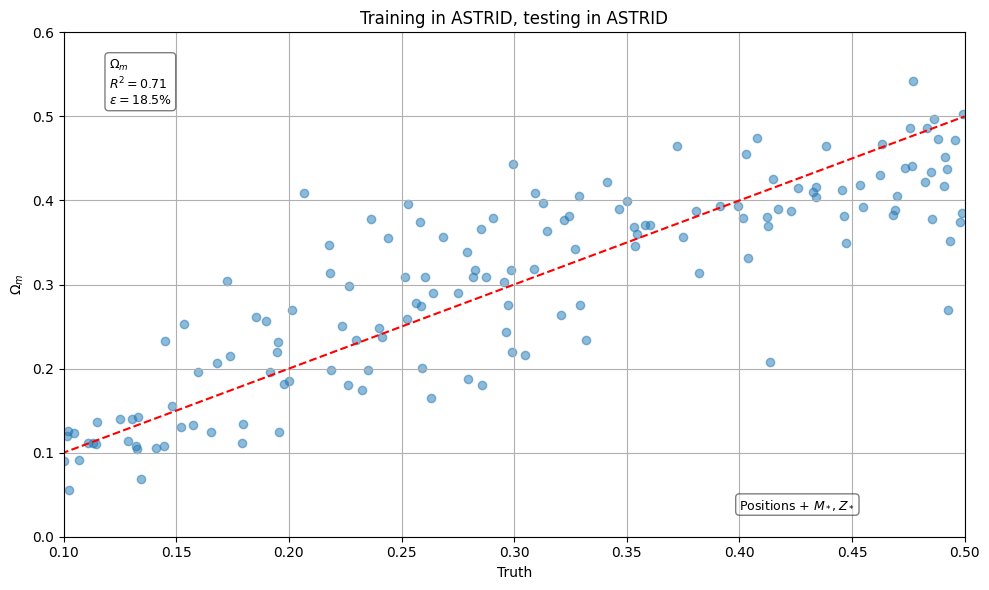

In [40]:
import matplotlib.pyplot as plt

# Evaluate model
test_predictions, test_true, r2, epsilon, test_mse = evaluate_model(trained_model, test_loader, device)

print(test_mse)

# Plot results
plt.figure(figsize=(10, 6))
plt.scatter(test_true, test_predictions, alpha=0.5)
plt.plot([0, 0.5], [0, 0.5], color='red', linestyle='--')  # Perfect prediction line

plt.xlabel('Truth')
plt.ylabel(r'$\Omega_m$')
plt.title('Training in ASTRID, testing in ASTRID')

# Add textbox with metrics
textstr = '\n'.join((
    r'$\Omega_m$',
    r'$R^2=%.2f$' % (r2,),
    r'$\epsilon=%.1f\%%$' % (epsilon*100,)
))
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=9,
         verticalalignment='top', bbox=props)

plt.text(0.75, 0.05, r'Positions + $M_*, Z_*$', transform=plt.gca().transAxes,
         fontsize=9, verticalalignment='bottom', bbox=props)

plt.xlim(0.1, 0.5)
plt.ylim(0, 0.6)
plt.grid(True)
plt.tight_layout()
plt.show()